In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

#import os
#os.environ["LD_LIBRARY_PATH"]="/local/cuda-10.2/lib64"
#sys.path.append("/local/cuda-10.2/bin")


import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy
import pandas as pd

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *
from turing.pinns_experimental import TINN_masked, TINN_multi_nodes

2022-08-19 23:27:08.076508: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-19 23:27:19.051313: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-08-19 23:27:19.091107: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-19 23:27:19.091158: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-08-19 23:27:19.093895: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-08-19 23:27:19.096577: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

In [2]:
df_params = pd.read_pickle("../../bacterialcolony_dataset/df_circuit2_variant5716gaussian_30000parametersets.pkl")

In [3]:
df_params.head()

,Va,Vb,Vc,Vd,Ve,Vf,ba,bb,bc,bd,...,kaa,kbd,kce,kda,keb,kee,kfe,mua,mulva,n
0,360.066204,69.840434,33.468912,283.316201,79.328098,35.847305,0.007714,0.009772,0.010261,0.008996,...,2.316063,2.874391,88.732068,9.363779,9.627162,0.275728,5.519184,4.664757,1.485684,2.0
1,271.955874,101.868916,28.546540,347.711607,84.727223,41.786928,0.008341,0.012020,0.013054,0.010064,...,4.883066,3.640181,99.577576,9.439324,7.552942,0.252092,4.607892,2.973656,1.423090,2.0
2,310.495835,79.551016,51.789526,197.624749,51.961358,40.627957,0.010750,0.015593,0.009346,0.013251,...,3.245317,4.944193,34.494922,13.954478,8.398245,0.299176,4.757444,4.151729,1.129469,2.0
3,368.363031,99.843451,51.223075,312.732434,89.436871,49.564425,0.008238,0.010022,0.007271,0.007357,...,2.941270,2.693431,89.807684,10.478264,7.656785,0.347844,6.552310,3.452419,1.213001,2.0
4,252.138904,90.823276,43.880020,293.190760,87.402367,59.800131,0.008995,0.008820,0.007773,0.011784,...,4.101435,3.625196,60.758534,9.479563,10.618988,0.174654,3.911595,4.190837,1.634196,2.0


In [4]:
import pickle

with open('../../bacterialcolony_dataset/2Dtimeseries_circuit2_variant5716gaussian_ca_fullcircuitID194_L10_J150_T120_N1200.pkl', 'rb') as f:
    ds_1 = pickle.load(f)
    
with open('../../bacterialcolony_dataset/caMask_seed1_pdivision0.5_L10_J150_T120_N1200.pkl', 'rb') as f:
    mask = pickle.load(f)


# Test two: Using mask

In [5]:
ID = 194
L = 10
data = np.array(ds_1)
nodes_n = data.shape[0]
node_names = ["A", "B", "C", "D", "E", "F"]
x_size = data.shape[1]
y_size = data.shape[2]
T = data.shape[3]
N = x_size*y_size

t_star = np.arange(0, T)

##########################
# select a subset of data
t_star = t_star[-2:]
T = len(t_star)
data = data[:, :, :, -2::]

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': T*N}


dataset = create_dataset_multi_nodes_mask(data, mask, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = np.float32(dataset['obs_input'])
obs_Y = np.float32(dataset['obs_output'])
pde_X = np.float32(dataset['pde'])[dataset['pde_mask'] > 0, :]


In [6]:
layers = [3, 256, 256, 512, 512, 1024, 1024, 6]
#layers = [3, 1024, 512, 256, 128, 64, 6]
#layers = [3, 1024, 1024, 512, 256, 128, 6]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_loss = Circuit2_variant5716(dtype=tf.float32, 
        D_A=df_params.d_A[ID],
        D_B = df_params.d_B[ID],
        b_A=df_params.ba[ID],
        b_B=df_params.bb[ID],
        b_C=df_params.bc[ID],
        b_D=df_params.bd[ID],
        b_E=df_params.be[ID],
        b_F=df_params.bf[ID],
        V_A=df_params.Va[ID],
        V_B=df_params.Vb[ID],
        V_C=df_params.Vc[ID],
        V_D=df_params.Vd[ID],
        V_E=df_params.Ve[ID],
        V_F=df_params.Vf[ID],
        k_AA=df_params.kaa[ID],
        k_BD=df_params.kbd[ID],
        k_CE=df_params.kce[ID],
        k_DA=df_params.kda[ID],
        k_EB=df_params.keb[ID],
        k_EE=df_params.kee[ID],
        k_FE=df_params.kfe[ID],
        mu_A=df_params.mua[ID],
        mulv_A=df_params.mulva[ID])

model = TINN_multi_nodes(pinn, 
                pde_loss, 
                nodes_n = nodes_n,
                node_names = node_names,
                optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                alpha = 0.9, 
                print_precision=".10f")

In [7]:
results = model.train(
        epochs = 100,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=1,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)

model.optimizer.lr.assign(1e-4)

results2 = model.train(
        epochs = 1000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)



Start of epoch 0


2022-08-19 23:27:37.970308: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-19 23:28:34.330761: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1153.4755859375
total loss: 18893.2615203857, total regularisd loss (sum of batches): 830773.0615234375
obs A loss: 7.2561543286, pde A loss: 7023.6460962296
obs B loss: 5.0375793278, pde B loss: 613.5547990005
obs C loss: 6.8149488121, pde C loss: 177.0380250514
obs D loss: 6539.3198394775, pde D loss: 3359.9956175322
obs E loss: 254.3047571182, pde E loss: 689.1290086018
obs F loss: 108.1197518110, pde F loss: 109.0445345115
lambda obs A: 1.0000000000, lambda pde A: 1.0000000000
lambda obs B: 1.0000000000, lambda pde B: 1.0000000000
lambda obs C: 1.0000000000, lambda pde C: 1.0000000000
lambda obs D: 1.0000000000, lambda pde D: 1.0000000000
lambda obs E: 1.0000000000, lambda pde E: 1.0000000000
lambda obs F: 1.0000000000, lambda pde F: 1.0000000000

Time taken: 166.32s

Start of epoch 1
Training observations acc over epoch: 1135.7028808594
total loss: 8940.6361846924, total regularisd loss (sum of batches): 393385.9931640625
obs A loss: 5.0069245

Training observations acc over epoch: 587.0399780273
total loss: 4426.8846130371, total regularisd loss (sum of batches): 1047580.1972656250
obs A loss: 5.1246017963, pde A loss: 344.0398836136
obs B loss: 3.1245442778, pde B loss: 139.5441710949
obs C loss: 4.4935547262, pde C loss: 9.6189245433
obs D loss: 3103.9273071289, pde D loss: 226.9835102558
obs E loss: 295.8088946342, pde E loss: 63.7244707346
obs F loss: 109.7609946728, pde F loss: 120.7337596416
lambda obs A: 0.3788278103, lambda pde A: 0.4010851979
lambda obs B: 0.3489422202, lambda pde B: 0.3596788943
lambda obs C: 0.3504193723, lambda pde C: 0.3494167328
lambda obs D: 7.9106726646, lambda pde D: 0.3594489396
lambda obs E: 0.4700498879, lambda pde E: 0.3520080447
lambda obs F: 0.3681090772, lambda pde F: 0.3513408899

Time taken: 9.60s

Start of epoch 11
Training observations acc over epoch: 553.3054199219
total loss: 4424.5877456665, total regularisd loss (sum of batches): 1037008.6796875000
obs A loss: 6.3294078112, pd

Training observations acc over epoch: 230.9713745117
total loss: 2420.8697090149, total regularisd loss (sum of batches): 359146.6865234375
obs A loss: 66.5304070711, pde A loss: 293.6029162407
obs B loss: 1.3094925247, pde B loss: 217.6467609406
obs C loss: 10.6945360601, pde C loss: 17.2257586569
obs D loss: 983.9343471527, pde D loss: 299.1190044880
obs E loss: 228.7975664139, pde E loss: 60.9692806005
obs F loss: 94.5617547035, pde F loss: 146.4778795242
lambda obs A: 0.2558352351, lambda pde A: 0.6016526818
lambda obs B: 0.1238790527, lambda pde B: 0.5878265500
lambda obs C: 0.1404325515, lambda pde C: 0.1351022273
lambda obs D: 7.3323211670, lambda pde D: 0.1885751784
lambda obs E: 1.6661212444, lambda pde E: 0.1910836101
lambda obs F: 0.5214725733, lambda pde F: 0.2556975484

Time taken: 9.62s

Start of epoch 21
Training observations acc over epoch: 228.5707092285
total loss: 2338.5185470581, total regularisd loss (sum of batches): 350473.0278320312
obs A loss: 73.7932412624, pd

Training observations acc over epoch: 198.1430511475
total loss: 2123.4548873901, total regularisd loss (sum of batches): 294501.2968750000
obs A loss: 64.1580015421, pde A loss: 308.2141747475
obs B loss: 1.3324010745, pde B loss: 131.9585592747
obs C loss: 6.0734627247, pde C loss: 25.8772096634
obs D loss: 879.9987106323, pde D loss: 357.1365032196
obs E loss: 151.9428839684, pde E loss: 78.4185972214
obs F loss: 85.3527334929, pde F loss: 32.9916532040
lambda obs A: 0.3588725030, lambda pde A: 0.3650062978
lambda obs B: 0.0456351861, lambda pde B: 0.4576652646
lambda obs C: 0.0729402825, lambda pde C: 0.0724063143
lambda obs D: 6.7779026031, lambda pde D: 0.1518397629
lambda obs E: 2.6659822464, lambda pde E: 0.1418707073
lambda obs F: 0.6853712797, lambda pde F: 0.2045066953

Time taken: 9.65s

Start of epoch 31
Training observations acc over epoch: 196.1591949463
total loss: 2115.9334144592, total regularisd loss (sum of batches): 294656.9638671875
obs A loss: 57.4499357939, pde 

Training observations acc over epoch: 174.7416229248
total loss: 2116.8815040588, total regularisd loss (sum of batches): 295793.1196289062
obs A loss: 24.4204780757, pde A loss: 293.9460010529
obs B loss: 2.7287160121, pde B loss: 161.1784620285
obs C loss: 4.0555784926, pde C loss: 23.0805412233
obs D loss: 850.8409309387, pde D loss: 402.8734838963
obs E loss: 115.1281669140, pde E loss: 159.7878431082
obs F loss: 51.2758509517, pde F loss: 27.5654539615
lambda obs A: 0.1848596036, lambda pde A: 0.2887735963
lambda obs B: 0.0183766019, lambda pde B: 0.2356278747
lambda obs C: 0.0404266752, lambda pde C: 0.0472935103
lambda obs D: 7.2624969482, lambda pde D: 0.1552624255
lambda obs E: 2.9614293575, lambda pde E: 0.1077730581
lambda obs F: 0.6128438115, lambda pde F: 0.0848359317

Time taken: 9.70s

Start of epoch 41
Training observations acc over epoch: 176.0449066162
total loss: 1692.7446365356, total regularisd loss (sum of batches): 294438.9291992188
obs A loss: 23.4678546786, pde

Training observations acc over epoch: 162.5516052246
total loss: 1375.8117256165, total regularisd loss (sum of batches): 302928.1210937500
obs A loss: 7.6024919227, pde A loss: 145.6668410301
obs B loss: 1.4633705895, pde B loss: 53.1286018491
obs C loss: 4.2760937288, pde C loss: 13.3015735298
obs D loss: 833.9628496170, pde D loss: 122.5857119560
obs E loss: 108.2696075439, pde E loss: 57.1003952622
obs F loss: 19.7354153693, pde F loss: 8.7187646031
lambda obs A: 0.0756513476, lambda pde A: 0.2378474772
lambda obs B: 0.0088490583, lambda pde B: 0.1265028119
lambda obs C: 0.0253777318, lambda pde C: 0.0317955576
lambda obs D: 7.8059310913, lambda pde D: 0.1177273095
lambda obs E: 3.1121783257, lambda pde E: 0.0741334036
lambda obs F: 0.3457907140, lambda pde F: 0.0382154547

Time taken: 9.60s

Start of epoch 51
Training observations acc over epoch: 166.8283843994
total loss: 1464.0686817169, total regularisd loss (sum of batches): 313976.8696289062
obs A loss: 6.5670766681, pde A lo

Training observations acc over epoch: 160.7324981689
total loss: 1437.7360839844, total regularisd loss (sum of batches): 308425.1274414062
obs A loss: 8.4920054451, pde A loss: 181.4249565601
obs B loss: 1.5856839195, pde B loss: 73.3916296959
obs C loss: 3.7705004737, pde C loss: 15.8625435531
obs D loss: 823.3546543121, pde D loss: 114.8622463942
obs E loss: 107.7361423969, pde E loss: 79.0966305733
obs F loss: 19.4559401274, pde F loss: 8.7031596228
lambda obs A: 0.0302501004, lambda pde A: 0.1955776513
lambda obs B: 0.0044440497, lambda pde B: 0.0817232132
lambda obs C: 0.0196375065, lambda pde C: 0.0237645376
lambda obs D: 8.0358114243, lambda pde D: 0.0905001685
lambda obs E: 3.2391555309, lambda pde E: 0.0486973226
lambda obs F: 0.2110028565, lambda pde F: 0.0194350686

Time taken: 9.71s

Start of epoch 61
Training observations acc over epoch: 161.2902069092
total loss: 1448.5961151123, total regularisd loss (sum of batches): 311460.8144531250
obs A loss: 5.3664614148, pde A lo

Training observations acc over epoch: 160.5500183105
total loss: 1507.2385673523, total regularisd loss (sum of batches): 309210.3706054688
obs A loss: 7.6214350685, pde A loss: 210.2792868614
obs B loss: 1.4178612884, pde B loss: 86.5824284554
obs C loss: 4.1412892640, pde C loss: 15.2440601438
obs D loss: 822.3152360916, pde D loss: 157.6314586401
obs E loss: 107.2827602625, pde E loss: 63.2502690554
obs F loss: 20.5216259956, pde F loss: 10.9508440644
lambda obs A: 0.0136306835, lambda pde A: 0.1746575981
lambda obs B: 0.0028617939, lambda pde B: 0.0623884089
lambda obs C: 0.0173981860, lambda pde C: 0.0191333909
lambda obs D: 8.0497713089, lambda pde D: 0.0788571537
lambda obs E: 3.3535335064, lambda pde E: 0.0423676483
lambda obs F: 0.1718714833, lambda pde F: 0.0135281412

Time taken: 9.68s

Start of epoch 71
Training observations acc over epoch: 161.8234710693
total loss: 1378.9968204498, total regularisd loss (sum of batches): 312907.3408203125
obs A loss: 5.0403539129, pde A l

Training observations acc over epoch: 161.9572753906
total loss: 1676.9610309601, total regularisd loss (sum of batches): 312908.3813476562
obs A loss: 6.8510080129, pde A loss: 285.7432353497
obs B loss: 1.2989215013, pde B loss: 144.7344435453
obs C loss: 4.1251290292, pde C loss: 16.8835918009
obs D loss: 829.2430915833, pde D loss: 184.8362215757
obs E loss: 107.7026014328, pde E loss: 62.2364795804
obs F loss: 22.5230343342, pde F loss: 10.7832718641
lambda obs A: 0.0083625065, lambda pde A: 0.1861781776
lambda obs B: 0.0022064080, lambda pde B: 0.0674886778
lambda obs C: 0.0159216970, lambda pde C: 0.0206292886
lambda obs D: 8.0222606659, lambda pde D: 0.0821807534
lambda obs E: 3.3726437092, lambda pde E: 0.0426852740
lambda obs F: 0.1665648520, lambda pde F: 0.0128763840

Time taken: 9.46s

Start of epoch 81
Training observations acc over epoch: 159.8191070557
total loss: 1687.0759086609, total regularisd loss (sum of batches): 307755.9028320312
obs A loss: 6.5291659385, pde A 

Training observations acc over epoch: 160.4883270264
total loss: 1555.4931221008, total regularisd loss (sum of batches): 307872.2036132812
obs A loss: 6.1148375608, pde A loss: 224.6910128593
obs B loss: 1.2824329864, pde B loss: 127.8447792530
obs C loss: 5.6380009279, pde C loss: 17.7985163629
obs D loss: 820.4368867874, pde D loss: 148.7453176975
obs E loss: 106.8266552687, pde E loss: 62.0447328687
obs F loss: 22.6310839951, pde F loss: 11.4388560504
lambda obs A: 0.0059803100, lambda pde A: 0.1937746108
lambda obs B: 0.0018605178, lambda pde B: 0.0676502064
lambda obs C: 0.0173613485, lambda pde C: 0.0238444824
lambda obs D: 7.9853129387, lambda pde D: 0.0774209946
lambda obs E: 3.3952152729, lambda pde E: 0.0462489799
lambda obs F: 0.1706708223, lambda pde F: 0.0146592231

Time taken: 9.70s

Start of epoch 91
Training observations acc over epoch: 159.4625701904
total loss: 2202.2729797363, total regularisd loss (sum of batches): 306700.8544921875
obs A loss: 9.2612643279, pde A 

Training observations acc over epoch: 154.1924743652
total loss: 1429.1347103119, total regularisd loss (sum of batches): 279773.2163085938
obs A loss: 5.4973948076, pde A loss: 187.8119847775
obs B loss: 1.5906805731, pde B loss: 113.9672917128
obs C loss: 8.8651059866, pde C loss: 34.2325948477
obs D loss: 771.2207326889, pde D loss: 92.2097723484
obs E loss: 107.2308740616, pde E loss: 58.1260754466
obs F loss: 30.7500945330, pde F loss: 17.6321028471
lambda obs A: 0.0073747826, lambda pde A: 0.3488848209
lambda obs B: 0.0020571097, lambda pde B: 0.1668435931
lambda obs C: 0.0276437812, lambda pde C: 0.0419803485
lambda obs D: 7.6380300522, lambda pde D: 0.1464825124
lambda obs E: 3.3293793201, lambda pde E: 0.0777177960
lambda obs F: 0.1891597062, lambda pde F: 0.0244456436

Time taken: 9.59s

Start of epoch 10
Training observations acc over epoch: 147.8270874023
total loss: 1032.6691894531, total regularisd loss (sum of batches): 288226.1728515625
obs A loss: 4.7519501895, pde A l


Start of epoch 100
Training observations acc over epoch: 138.0591583252
total loss: 1092.4327278137, total regularisd loss (sum of batches): 270280.1723632812
obs A loss: 4.5867812485, pde A loss: 75.8206660748
obs B loss: 1.2190097850, pde B loss: 41.7151035666
obs C loss: 2.9380871430, pde C loss: 8.8165080994
obs D loss: 704.8953256607, pde D loss: 83.8916724920
obs E loss: 100.6019135714, pde E loss: 49.0790919662
obs F loss: 14.1140227020, pde F loss: 4.7545433864
lambda obs A: 0.0040278547, lambda pde A: 0.0687239096
lambda obs B: 0.0018790076, lambda pde B: 0.0140898842
lambda obs C: 0.0133636780, lambda pde C: 0.0106915487
lambda obs D: 8.1861763000, lambda pde D: 0.0515534505
lambda obs E: 3.5201971531, lambda pde E: 0.0151085528
lambda obs F: 0.1056960821, lambda pde F: 0.0084928349

Time taken: 97.31s

Start of epoch 110
Training observations acc over epoch: 135.5300140381
total loss: 1067.1500492096, total regularisd loss (sum of batches): 265501.4912109375
obs A loss: 4.4


Start of epoch 200
Training observations acc over epoch: 123.0036926270
total loss: 989.2108116150, total regularisd loss (sum of batches): 249361.6000976562
obs A loss: 4.5234364495, pde A loss: 67.0190074444
obs B loss: 1.1995628718, pde B loss: 31.5052005053
obs C loss: 1.8423098605, pde C loss: 5.7663236782
obs D loss: 630.0852823257, pde D loss: 90.4602550268
obs E loss: 89.9526280165, pde E loss: 53.0301280022
obs F loss: 10.4188216180, pde F loss: 3.4078455418
lambda obs A: 0.0056314939, lambda pde A: 0.0836224109
lambda obs B: 0.0022552432, lambda pde B: 0.0163702331
lambda obs C: 0.0204688888, lambda pde C: 0.0089881551
lambda obs D: 8.5235881805, lambda pde D: 0.0914681256
lambda obs E: 3.1181924343, lambda pde E: 0.0183833539
lambda obs F: 0.1033271477, lambda pde F: 0.0077032088

Time taken: 95.89s

Start of epoch 210
Training observations acc over epoch: 122.2331085205
total loss: 985.7424907684, total regularisd loss (sum of batches): 247227.0629882812
obs A loss: 4.5435


Start of epoch 300
Training observations acc over epoch: 111.9397888184
total loss: 910.0286579132, total regularisd loss (sum of batches): 235682.0522460938
obs A loss: 3.9558607489, pde A loss: 61.2637431622
obs B loss: 1.1678835154, pde B loss: 27.0215538144
obs C loss: 1.6028567236, pde C loss: 4.9122502953
obs D loss: 575.6338663101, pde D loss: 92.5189001560
obs E loss: 80.6972576380, pde E loss: 49.1934339404
obs F loss: 8.5811552107, pde F loss: 3.4798955061
lambda obs A: 0.0059284498, lambda pde A: 0.1046189964
lambda obs B: 0.0029178567, lambda pde B: 0.0233893003
lambda obs C: 0.0352698378, lambda pde C: 0.0095740352
lambda obs D: 8.8896493912, lambda pde D: 0.1101373136
lambda obs E: 2.6759650707, lambda pde E: 0.0232610758
lambda obs F: 0.1096986830, lambda pde F: 0.0095903538

Time taken: 97.26s

Start of epoch 310
Training observations acc over epoch: 110.6672439575
total loss: 905.9011287689, total regularisd loss (sum of batches): 233026.3901367188
obs A loss: 3.96872


Start of epoch 400
Training observations acc over epoch: 102.2219772339
total loss: 863.4808864594, total regularisd loss (sum of batches): 219718.6669921875
obs A loss: 3.3366880640, pde A loss: 69.8890415430
obs B loss: 1.1215067971, pde B loss: 27.7018730044
obs C loss: 1.5127708893, pde C loss: 4.4871565923
obs D loss: 526.4775114059, pde D loss: 97.1641684771
obs E loss: 73.2502825260, pde E loss: 47.3985668421
obs F loss: 7.6329531521, pde F loss: 3.5083669275
lambda obs A: 0.0057945410, lambda pde A: 0.1136333048
lambda obs B: 0.0038806731, lambda pde B: 0.0265083332
lambda obs C: 0.0406271070, lambda pde C: 0.0110293096
lambda obs D: 9.1121931076, lambda pde D: 0.1534017473
lambda obs E: 2.3740382195, lambda pde E: 0.0267767143
lambda obs F: 0.1201236621, lambda pde F: 0.0119929025

Time taken: 95.84s

Start of epoch 410
Training observations acc over epoch: 100.9672698975
total loss: 833.7030458450, total regularisd loss (sum of batches): 218108.9162597656
obs A loss: 3.31483


Start of epoch 500
Training observations acc over epoch: 94.7667083740
total loss: 822.5834903717, total regularisd loss (sum of batches): 205303.6186523438
obs A loss: 3.2057695687, pde A loss: 81.6846238375
obs B loss: 1.0486928951, pde B loss: 27.1573123634
obs C loss: 1.4204809722, pde C loss: 4.1736752689
obs D loss: 488.3554954529, pde D loss: 97.2076438665
obs E loss: 67.4064205885, pde E loss: 40.2010405064
obs F loss: 7.1633778214, pde F loss: 3.5589531511
lambda obs A: 0.0062199901, lambda pde A: 0.1270213127
lambda obs B: 0.0045485394, lambda pde B: 0.0317228884
lambda obs C: 0.0404233634, lambda pde C: 0.0121710375
lambda obs D: 9.1689548492, lambda pde D: 0.1954858601
lambda obs E: 2.2359929085, lambda pde E: 0.0325297788
lambda obs F: 0.1292634159, lambda pde F: 0.0156658869

Time taken: 95.25s

Start of epoch 510
Training observations acc over epoch: 92.3579788208
total loss: 786.8129358292, total regularisd loss (sum of batches): 198491.0864257812
obs A loss: 3.2112995


Start of epoch 600
Training observations acc over epoch: 85.3363494873
total loss: 740.2521190643, total regularisd loss (sum of batches): 183923.5671386719
obs A loss: 2.9351863377, pde A loss: 66.1791311502
obs B loss: 0.9703457467, pde B loss: 24.8082826734
obs C loss: 1.3555929493, pde C loss: 4.2890344188
obs D loss: 438.7519235611, pde D loss: 91.1538372040
obs E loss: 61.6134501696, pde E loss: 38.4908827543
obs F loss: 6.3916119486, pde F loss: 3.3128510714
lambda obs A: 0.0072005959, lambda pde A: 0.1638300717
lambda obs B: 0.0054649394, lambda pde B: 0.0348943397
lambda obs C: 0.0426488295, lambda pde C: 0.0162094235
lambda obs D: 9.1453218460, lambda pde D: 0.2411982417
lambda obs E: 2.1475903988, lambda pde E: 0.0369570255
lambda obs F: 0.1383292228, lambda pde F: 0.0203550123

Time taken: 95.00s

Start of epoch 610
Training observations acc over epoch: 84.3350143433
total loss: 732.8131790161, total regularisd loss (sum of batches): 182484.1599121094
obs A loss: 3.0880260


Start of epoch 700
Training observations acc over epoch: 76.3693923950
total loss: 668.0564765930, total regularisd loss (sum of batches): 162235.3339843750
obs A loss: 3.0010967515, pde A loss: 64.9167898893
obs B loss: 0.9004564192, pde B loss: 23.2617383897
obs C loss: 1.2626642752, pde C loss: 4.2654073313
obs D loss: 391.6446428299, pde D loss: 80.7376747131
obs E loss: 55.6120414734, pde E loss: 33.4572323561
obs F loss: 5.7954312861, pde F loss: 3.2012924105
lambda obs A: 0.0087721460, lambda pde A: 0.2075201571
lambda obs B: 0.0067510549, lambda pde B: 0.0429546759
lambda obs C: 0.0481900871, lambda pde C: 0.0205378626
lambda obs D: 8.9996328354, lambda pde D: 0.2923155129
lambda obs E: 2.1523177624, lambda pde E: 0.0467949733
lambda obs F: 0.1489202082, lambda pde F: 0.0252926014

Time taken: 94.67s

Start of epoch 710
Training observations acc over epoch: 75.6827545166
total loss: 673.9863033295, total regularisd loss (sum of batches): 160937.1118164062
obs A loss: 2.9955544


Start of epoch 800
Training observations acc over epoch: 67.3363571167
total loss: 608.9430751801, total regularisd loss (sum of batches): 141733.2668457031
obs A loss: 2.9189552628, pde A loss: 66.5081677437
obs B loss: 0.8541878425, pde B loss: 22.1268502474
obs C loss: 1.1860045642, pde C loss: 4.2757566944
obs D loss: 344.1286425591, pde D loss: 77.7690840960
obs E loss: 49.5821298957, pde E loss: 31.1325780749
obs F loss: 5.3482533544, pde F loss: 3.1124591455
lambda obs A: 0.0112296119, lambda pde A: 0.2527993321
lambda obs B: 0.0082135778, lambda pde B: 0.0520675406
lambda obs C: 0.0518895015, lambda pde C: 0.0245093852
lambda obs D: 8.9099969864, lambda pde D: 0.3322264850
lambda obs E: 2.1103830338, lambda pde E: 0.0536616780
lambda obs F: 0.1610462666, lambda pde F: 0.0319754370

Time taken: 94.80s

Start of epoch 810
Training observations acc over epoch: 66.9942092896
total loss: 609.0168771744, total regularisd loss (sum of batches): 140875.9345703125
obs A loss: 2.8955773


Start of epoch 900
Training observations acc over epoch: 58.5164680481
total loss: 532.0231494904, total regularisd loss (sum of batches): 120973.8116455078
obs A loss: 2.8683296256, pde A loss: 60.8697153926
obs B loss: 0.7878851453, pde B loss: 19.5059354305
obs C loss: 1.1071196645, pde C loss: 4.0332352631
obs D loss: 297.7291970253, pde D loss: 66.2826883793
obs E loss: 43.8245499134, pde E loss: 27.5332095027
obs F loss: 4.7817385495, pde F loss: 2.6995462812
lambda obs A: 0.0146364663, lambda pde A: 0.2977559566
lambda obs B: 0.0098563088, lambda pde B: 0.0687788129
lambda obs C: 0.0586970299, lambda pde C: 0.0308872834
lambda obs D: 8.7715835571, lambda pde D: 0.3650113940
lambda obs E: 2.1108672619, lambda pde E: 0.0615224093
lambda obs F: 0.1750981957, lambda pde F: 0.0353060625

Time taken: 94.84s

Start of epoch 910
Training observations acc over epoch: 57.6623153687
total loss: 524.7250947952, total regularisd loss (sum of batches): 119469.6743164062
obs A loss: 2.9123142

In [8]:
results3 = model.train(
        epochs = 1000,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 51.5572319031
total loss: 475.0019865036, total regularisd loss (sum of batches): 105642.6936035156
obs A loss: 2.8563426770, pde A loss: 59.1112076044
obs B loss: 0.7399051292, pde B loss: 17.8778715730
obs C loss: 1.0460813716, pde C loss: 3.9466522634
obs D loss: 261.3987488747, pde D loss: 58.2542936802
obs E loss: 39.0578101873, pde E loss: 24.2619101107
obs F loss: 4.2444782406, pde F loss: 2.2066858858
lambda obs A: 0.0183314290, lambda pde A: 0.3568772376
lambda obs B: 0.0114286169, lambda pde B: 0.0766388923
lambda obs C: 0.0648858771, lambda pde C: 0.0365708247
lambda obs D: 8.6937513351, lambda pde D: 0.3846524060
lambda obs E: 2.0769290924, lambda pde E: 0.0624147095
lambda obs F: 0.1799663752, lambda pde F: 0.0375537090

Time taken: 9.74s

Start of epoch 10
Training observations acc over epoch: 51.7891120911
total loss: 478.0609121323, total regularisd loss (sum of batches): 105923.6877441406
obs A loss: 2.8334263712,

Training observations acc over epoch: 45.9701881409
total loss: 434.0540480614, total regularisd loss (sum of batches): 93102.2857666016
obs A loss: 2.8127150983, pde A loss: 60.2677862644
obs B loss: 0.7002724363, pde B loss: 18.0658030510
obs C loss: 0.9985425025, pde C loss: 3.7680585310
obs D loss: 232.2933549881, pde D loss: 52.2294692993
obs E loss: 35.1760309339, pde E loss: 21.7831101418
obs F loss: 3.8402022868, pde F loss: 2.1186978407
lambda obs A: 0.0227324162, lambda pde A: 0.4175724685
lambda obs B: 0.0140553769, lambda pde B: 0.0882274285
lambda obs C: 0.0729479566, lambda pde C: 0.0435597524
lambda obs D: 8.5839891434, lambda pde D: 0.3974630535
lambda obs E: 2.0525588989, lambda pde E: 0.0707738176
lambda obs F: 0.1916441619, lambda pde F: 0.0444766730

Time taken: 94.68s

Start of epoch 110
Training observations acc over epoch: 46.0107002258
total loss: 441.3015975952, total regularisd loss (sum of batches): 93352.7768554688
obs A loss: 2.8110010847, pde A loss: 62.18

Training observations acc over epoch: 41.4315414429
total loss: 402.7649850845, total regularisd loss (sum of batches): 83196.2910156250
obs A loss: 2.7798051275, pde A loss: 62.9891568422
obs B loss: 0.6722491020, pde B loss: 16.4879955351
obs C loss: 0.9483021311, pde C loss: 3.7913113013
obs D loss: 208.9491081238, pde D loss: 48.5633646250
obs E loss: 31.7821277380, pde E loss: 20.2957154214
obs F loss: 3.4576383457, pde F loss: 2.0482088290
lambda obs A: 0.0274651460, lambda pde A: 0.4608070254
lambda obs B: 0.0161339529, lambda pde B: 0.1003954411
lambda obs C: 0.0821069330, lambda pde C: 0.0502610430
lambda obs D: 8.4566507339, lambda pde D: 0.4118323624
lambda obs E: 2.0753564835, lambda pde E: 0.0720968768
lambda obs F: 0.1957094222, lambda pde F: 0.0511848554

Time taken: 94.74s

Start of epoch 210
Training observations acc over epoch: 39.5169296265
total loss: 375.2640390396, total regularisd loss (sum of batches): 78823.9847412109
obs A loss: 2.6296255067, pde A loss: 50.32

Training observations acc over epoch: 35.7519264221
total loss: 348.2809114456, total regularisd loss (sum of batches): 70347.7606201172
obs A loss: 2.7589056641, pde A loss: 51.8176786304
obs B loss: 0.6322974302, pde B loss: 15.3303174078
obs C loss: 0.9070552643, pde C loss: 3.4990040511
obs D loss: 178.9078965187, pde D loss: 42.2825265527
obs E loss: 28.2361296713, pde E loss: 18.8981582224
obs F loss: 3.0692708082, pde F loss: 1.9416712634
lambda obs A: 0.0333548225, lambda pde A: 0.4781057835
lambda obs B: 0.0191540085, lambda pde B: 0.1098943800
lambda obs C: 0.0939005762, lambda pde C: 0.0572806597
lambda obs D: 8.3483896255, lambda pde D: 0.4447206855
lambda obs E: 2.0718073845, lambda pde E: 0.0781541616
lambda obs F: 0.2067159414, lambda pde F: 0.0585218892

Time taken: 97.57s

Start of epoch 310
Training observations acc over epoch: 35.7405815125
total loss: 349.8298912048, total regularisd loss (sum of batches): 69876.5249023438
obs A loss: 2.6813733988, pde A loss: 55.13

Training observations acc over epoch: 32.4510116577
total loss: 331.0939264297, total regularisd loss (sum of batches): 62015.8659667969
obs A loss: 2.6302732751, pde A loss: 55.1986346245
obs B loss: 0.6369050704, pde B loss: 13.9861515015
obs C loss: 0.8818837516, pde C loss: 3.4260366149
obs D loss: 162.2768709660, pde D loss: 43.0524032712
obs E loss: 25.4061771631, pde E loss: 18.7977153957
obs F loss: 2.8740009442, pde F loss: 1.9268689454
lambda obs A: 0.0425951630, lambda pde A: 0.6228005886
lambda obs B: 0.0248334110, lambda pde B: 0.1278997213
lambda obs C: 0.1110188290, lambda pde C: 0.0713160336
lambda obs D: 7.9697322845, lambda pde D: 0.4734938145
lambda obs E: 2.1652469635, lambda pde E: 0.0940030888
lambda obs F: 0.2240825742, lambda pde F: 0.0729767606

Time taken: 97.22s

Start of epoch 410
Training observations acc over epoch: 31.2332992554
total loss: 312.3679680824, total regularisd loss (sum of batches): 59777.7093505859
obs A loss: 2.6427656151, pde A loss: 50.07

Training observations acc over epoch: 27.5458221436
total loss: 280.1018595695, total regularisd loss (sum of batches): 51572.9036254883
obs A loss: 2.5880085491, pde A loss: 47.4207006693
obs B loss: 0.6143196728, pde B loss: 11.7370662689
obs C loss: 0.8253163667, pde C loss: 3.1844535656
obs D loss: 136.2771949768, pde D loss: 34.5165143013
obs E loss: 22.4340892732, pde E loss: 16.2399663925
obs F loss: 2.5360223055, pde F loss: 1.7282045819
lambda obs A: 0.0513857901, lambda pde A: 0.6644777060
lambda obs B: 0.0301949959, lambda pde B: 0.1510905474
lambda obs C: 0.1305757761, lambda pde C: 0.0810402930
lambda obs D: 7.8410663605, lambda pde D: 0.5007280111
lambda obs E: 2.1309721470, lambda pde E: 0.1006887406
lambda obs F: 0.2346414179, lambda pde F: 0.0831386149

Time taken: 97.17s

Start of epoch 510
Training observations acc over epoch: 26.9504528046
total loss: 272.8166079521, total regularisd loss (sum of batches): 50068.3081054688
obs A loss: 2.5286538638, pde A loss: 46.62

Training observations acc over epoch: 23.7265357971
total loss: 244.2395358086, total regularisd loss (sum of batches): 43256.1217651367
obs A loss: 2.5443425588, pde A loss: 43.8861466050
obs B loss: 0.5999975987, pde B loss: 11.3829870373
obs C loss: 0.7934267996, pde C loss: 3.0148747079
obs D loss: 116.2479579449, pde D loss: 28.0167292953
obs E loss: 19.9721657634, pde E loss: 14.0036081672
obs F loss: 2.2013428621, pde F loss: 1.5759557504
lambda obs A: 0.0631718561, lambda pde A: 0.7345879674
lambda obs B: 0.0358059779, lambda pde B: 0.1692269742
lambda obs C: 0.1475138217, lambda pde C: 0.0915232301
lambda obs D: 7.6547183990, lambda pde D: 0.5191572905
lambda obs E: 2.1562702656, lambda pde E: 0.1002339050
lambda obs F: 0.2371108234, lambda pde F: 0.0906801894

Time taken: 95.86s

Start of epoch 610
Training observations acc over epoch: 25.0015411377
total loss: 267.7581868172, total regularisd loss (sum of batches): 46065.4282226562
obs A loss: 2.5307024159, pde A loss: 56.23

Training observations acc over epoch: 21.2107410431
total loss: 223.2992720604, total regularisd loss (sum of batches): 37890.5419921875
obs A loss: 2.5103834607, pde A loss: 41.2298762202
obs B loss: 0.5727116968, pde B loss: 10.5259227604
obs C loss: 0.7522758981, pde C loss: 2.7842010148
obs D loss: 103.4723871946, pde D loss: 26.5182674229
obs E loss: 17.9999947846, pde E loss: 13.5485852361
obs F loss: 1.9566798471, pde F loss: 1.4279849175
lambda obs A: 0.0768859088, lambda pde A: 0.8138694167
lambda obs B: 0.0422810502, lambda pde B: 0.1973492354
lambda obs C: 0.1687875092, lambda pde C: 0.1009856761
lambda obs D: 7.4192357063, lambda pde D: 0.5203563571
lambda obs E: 2.2013220787, lambda pde E: 0.1235640943
lambda obs F: 0.2364937216, lambda pde F: 0.0988692939

Time taken: 95.73s

Start of epoch 710
Training observations acc over epoch: 21.5231590271
total loss: 228.2884664536, total regularisd loss (sum of batches): 38399.9360961914
obs A loss: 2.4613902420, pde A loss: 42.26


Start of epoch 810
Training observations acc over epoch: 18.7550506592
total loss: 204.9589622021, total regularisd loss (sum of batches): 32782.0890502930
obs A loss: 2.4517530948, pde A loss: 41.3154913187
obs B loss: 0.5508037657, pde B loss: 9.4503223747
obs C loss: 0.7274818327, pde C loss: 2.6221412979
obs D loss: 90.7928340435, pde D loss: 25.4137171209
obs E loss: 16.3563931882, pde E loss: 12.3817575574
obs F loss: 1.6510374043, pde F loss: 1.2452291716
lambda obs A: 0.0957717746, lambda pde A: 0.9393481612
lambda obs B: 0.0515928380, lambda pde B: 0.2120416015
lambda obs C: 0.1974696815, lambda pde C: 0.1184586883
lambda obs D: 7.1707067490, lambda pde D: 0.5239226222
lambda obs E: 2.2312088013, lambda pde E: 0.1278867424
lambda obs F: 0.2291419655, lambda pde F: 0.1024507955

Time taken: 95.04s

Start of epoch 820
Training observations acc over epoch: 18.8509654999
total loss: 204.3375973701, total regularisd loss (sum of batches): 32824.2747802734
obs A loss: 2.4340130389,

Training observations acc over epoch: 18.1009292603
total loss: 201.5632450581, total regularisd loss (sum of batches): 31244.8313293457
obs A loss: 2.4046940841, pde A loss: 42.6256415844
obs B loss: 0.5409762664, pde B loss: 9.8203616291
obs C loss: 0.7068063999, pde C loss: 2.5349425860
obs D loss: 88.1572393179, pde D loss: 24.9546208680
obs E loss: 15.2497857213, pde E loss: 11.8530560136
obs F loss: 1.5460710526, pde F loss: 1.1690497510
lambda obs A: 0.1139698699, lambda pde A: 1.0671263933
lambda obs B: 0.0615217835, lambda pde B: 0.2316140532
lambda obs C: 0.2200066298, lambda pde C: 0.1347194463
lambda obs D: 6.9126262665, lambda pde D: 0.5275070071
lambda obs E: 2.2644844055, lambda pde E: 0.1310768872
lambda obs F: 0.2231101692, lambda pde F: 0.1122367829

Time taken: 95.31s

Start of epoch 920
Training observations acc over epoch: 17.4969978333
total loss: 199.4362668991, total regularisd loss (sum of batches): 30320.8810424805
obs A loss: 2.4055790678, pde A loss: 46.3362

In [ ]:
results4 = model.train(
        epochs = 500,
        batch_size = 1024,
        X = obs_X,
        Y = obs_Y,
        print_interval=10,
        stop_threshold=0,
        shuffle=True,
        sample_losses=True,
        sample_parameters=True,
        sample_regularisations=True,
        sample_gradients=True,
        regularise=True)


Start of epoch 0
Training observations acc over epoch: 15.4215097427
total loss: 181.1483008862, total regularisd loss (sum of batches): 28061.0942687988
obs A loss: 2.5316994339, pde A loss: 34.9338648617
obs B loss: 0.5661990363, pde B loss: 7.9912339151
obs C loss: 0.7372689256, pde C loss: 2.4815322831
obs D loss: 80.7084268332, pde D loss: 22.7323865891
obs E loss: 14.8153348714, pde E loss: 11.1386610866
obs F loss: 1.4145217109, pde F loss: 1.0971729290
lambda obs A: 0.1283090562, lambda pde A: 1.0798401833
lambda obs B: 0.0691692531, lambda pde B: 0.2535082996
lambda obs C: 0.2458515912, lambda pde C: 0.1461565197
lambda obs D: 6.8116083145, lambda pde D: 0.5121946931
lambda obs E: 2.3034110069, lambda pde E: 0.1256065071
lambda obs F: 0.2167622745, lambda pde F: 0.1075813770

Time taken: 9.32s

Start of epoch 10
Training observations acc over epoch: 14.9961557388
total loss: 165.6908509731, total regularisd loss (sum of batches): 24932.9513549805
obs A loss: 2.3821225688, pde


Start of epoch 110
Training observations acc over epoch: 13.9169788361
total loss: 157.5324125290, total regularisd loss (sum of batches): 23000.2496337891
obs A loss: 2.3029846922, pde A loss: 35.2615785003
obs B loss: 0.5025798092, pde B loss: 7.2942602485
obs C loss: 0.6581160631, pde C loss: 2.1587417275
obs D loss: 66.4390926957, pde D loss: 18.5901913643
obs E loss: 12.4195932001, pde E loss: 9.7748936415
obs F loss: 1.1795079652, pde F loss: 0.9508720823
lambda obs A: 0.1491621286, lambda pde A: 1.1516772509
lambda obs B: 0.0809265375, lambda pde B: 0.2622209787
lambda obs C: 0.2802780271, lambda pde C: 0.1613967717
lambda obs D: 6.5897784233, lambda pde D: 0.5282080770
lambda obs E: 2.3242378235, lambda pde E: 0.1415866762
lambda obs F: 0.2140282243, lambda pde F: 0.1164991334

Time taken: 95.10s

Start of epoch 120
Training observations acc over epoch: 13.9702177048
total loss: 156.3951199055, total regularisd loss (sum of batches): 22931.1547241211
obs A loss: 2.2763545737, 

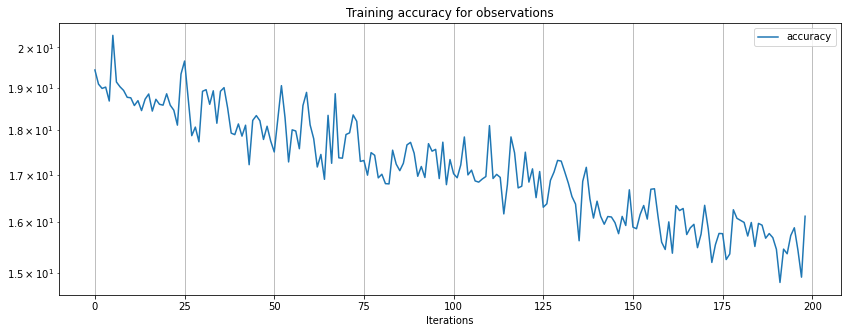

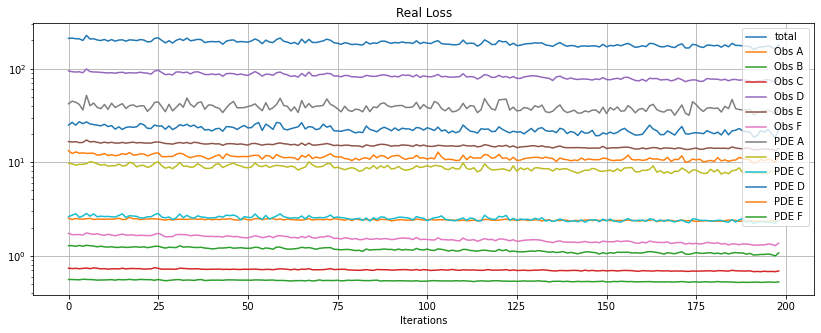

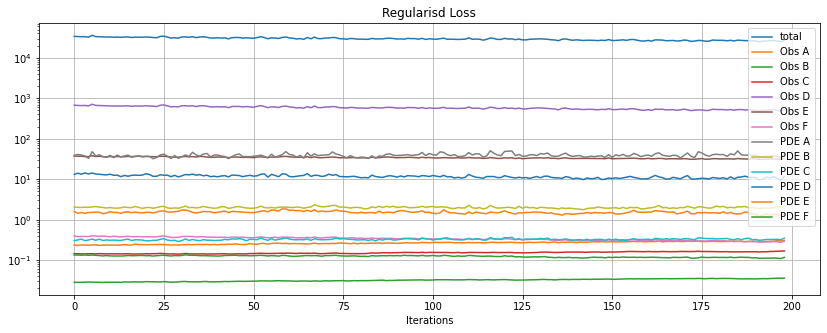

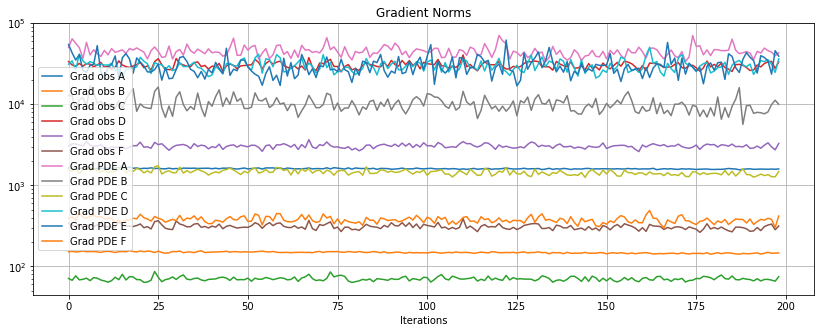

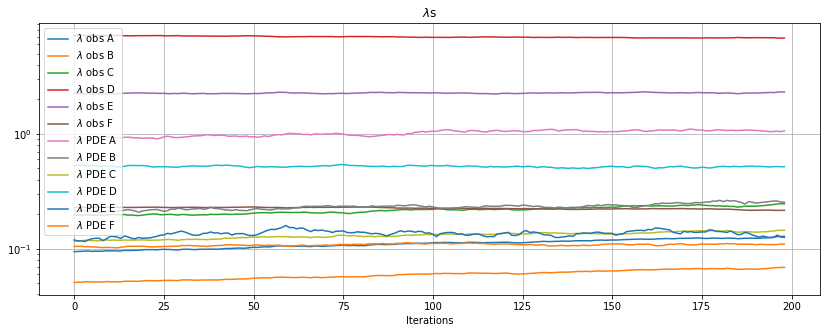

In [19]:
plot_result_multi_nodes(merge_dict_multi_nodes(results, results2, results3), 
                        node_names=node_names, start=1900,end=-1,  yscale='log')

In [44]:
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)
N2 = x_size * y_size

T_test_index = 0#119
print(t_star[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(t_star[T_test_index], N2)  # 1 x N2

116


In [45]:
output_test = pinn(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

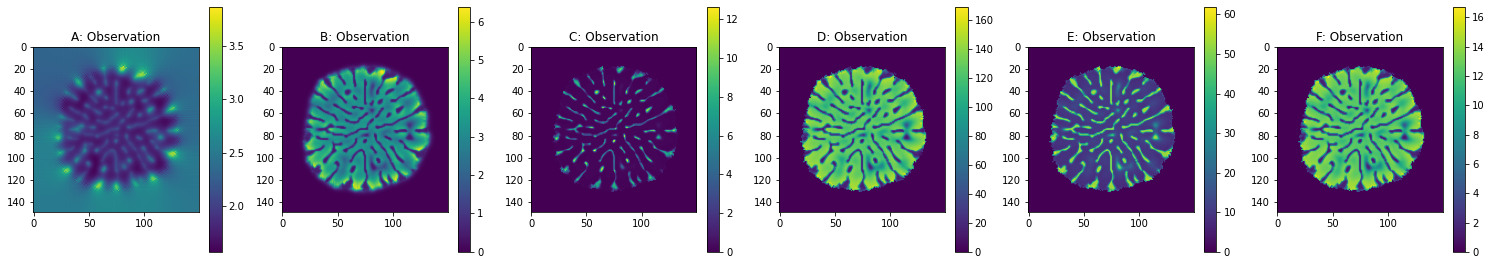

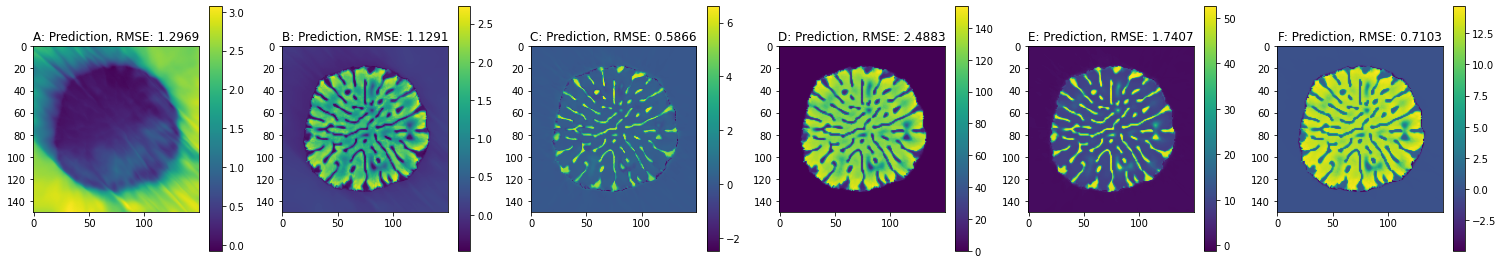

In [46]:
data_original = np.array(ds_1)
_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data_original[i,:, :, t_star[T_test_index]])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(26,6))
for i, name in enumerate(node_names):
    plt.subplot(1, 6, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data_original[i,:, :, t_star[T_test_index]])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

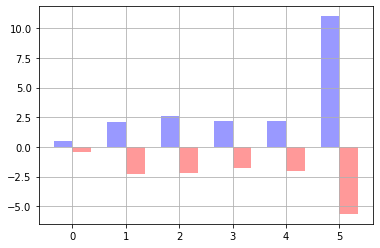

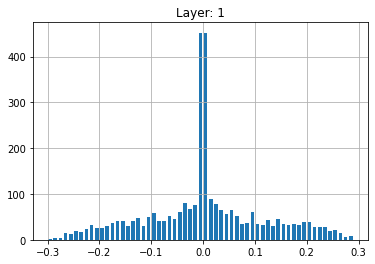

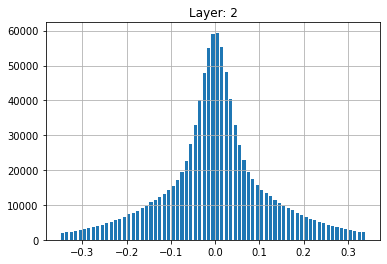

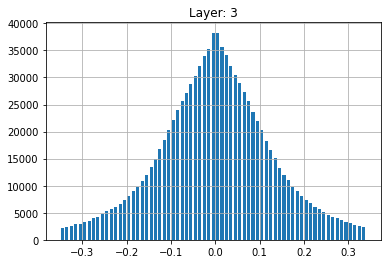

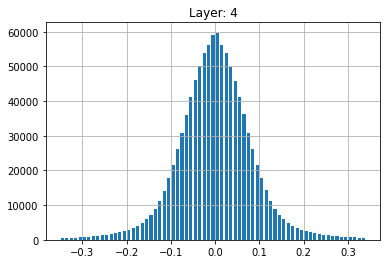

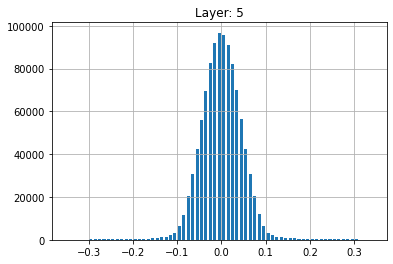

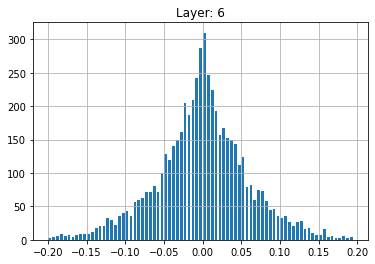

In [47]:
max_ws = np.zeros(len(pinn.Ws))
min_ws = np.zeros(len(pinn.Ws))
for i in range(len(pinn.Ws)):
    max_ws[i] = np.max(pinn.Ws[i].numpy())
    min_ws[i] = np.min(pinn.Ws[i].numpy())
    
index = np.arange(len(pinn.Ws))
bar_width = .35
plt.bar(index , max_ws, bar_width, color='b', alpha = .4)
plt.bar(index + bar_width, min_ws, bar_width, color='r', alpha = .4)

plt.xticks(index + bar_width/2, index)
plt.grid()
plt.show()

#bins = np.zeros((len(pinn.Ws), 50))
#hists = np.zeros((len(pinn.Ws), 49))
for i in range(len(pinn.Ws)):    
    if i == 0:
        bins = np.arange(-.3,.3,.01)
    elif i >= 1 and i <=4:
        bins = np.arange(-.35,0.35,.01)
    else:
        bins = np.arange(-.2,0.2,.005)
    #max_ws = np.max(pinn.Ws[i].numpy())
    #min_ws = np.min(pinn.Ws[i].numpy())
    #bins = np.arange(min_ws*.8, max_ws*.8, .8*(max_ws - min_ws)/20)
    hists, bins = np.histogram(pinn.Ws[i].numpy(), bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hists, align='center', width=width)
    plt.grid()
    plt.title(f"Layer: {i+1}")
    plt.show()


In [48]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T

In [49]:
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pdes = np.zeros((test_d.shape[0], len(node_names)))

for i, _ in enumerate(test_d):
    outs, pde_outs = pde_loss.loss_multi_nodes(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pdes[i] = [item.numpy() for item in pde_outs]

In [50]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pdes = np.array([ test_pdes[:, i].reshape((x_size, y_size)) for i in range(test_pdes.shape[1])]) 

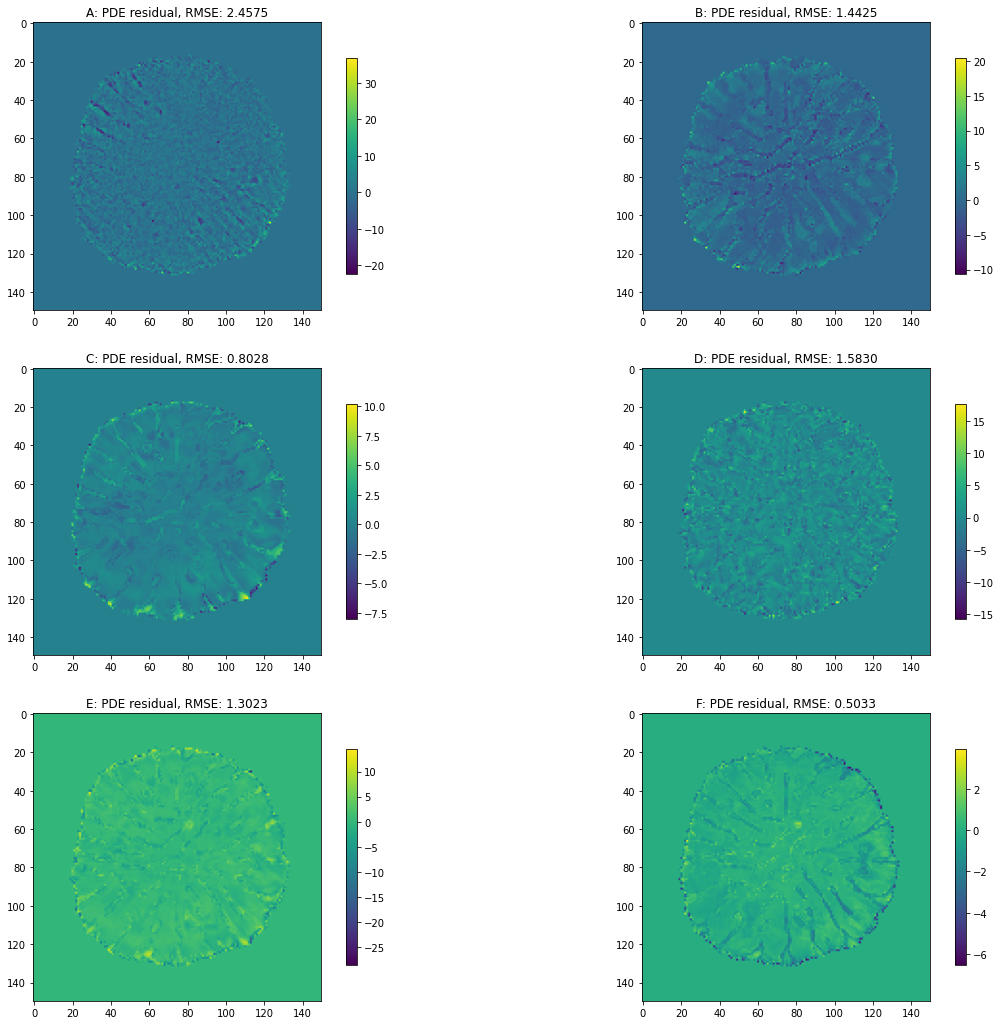

In [51]:
_ = plt.figure(figsize=(20,18))
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual, RMSE: {rmse:.4f}")
    
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()

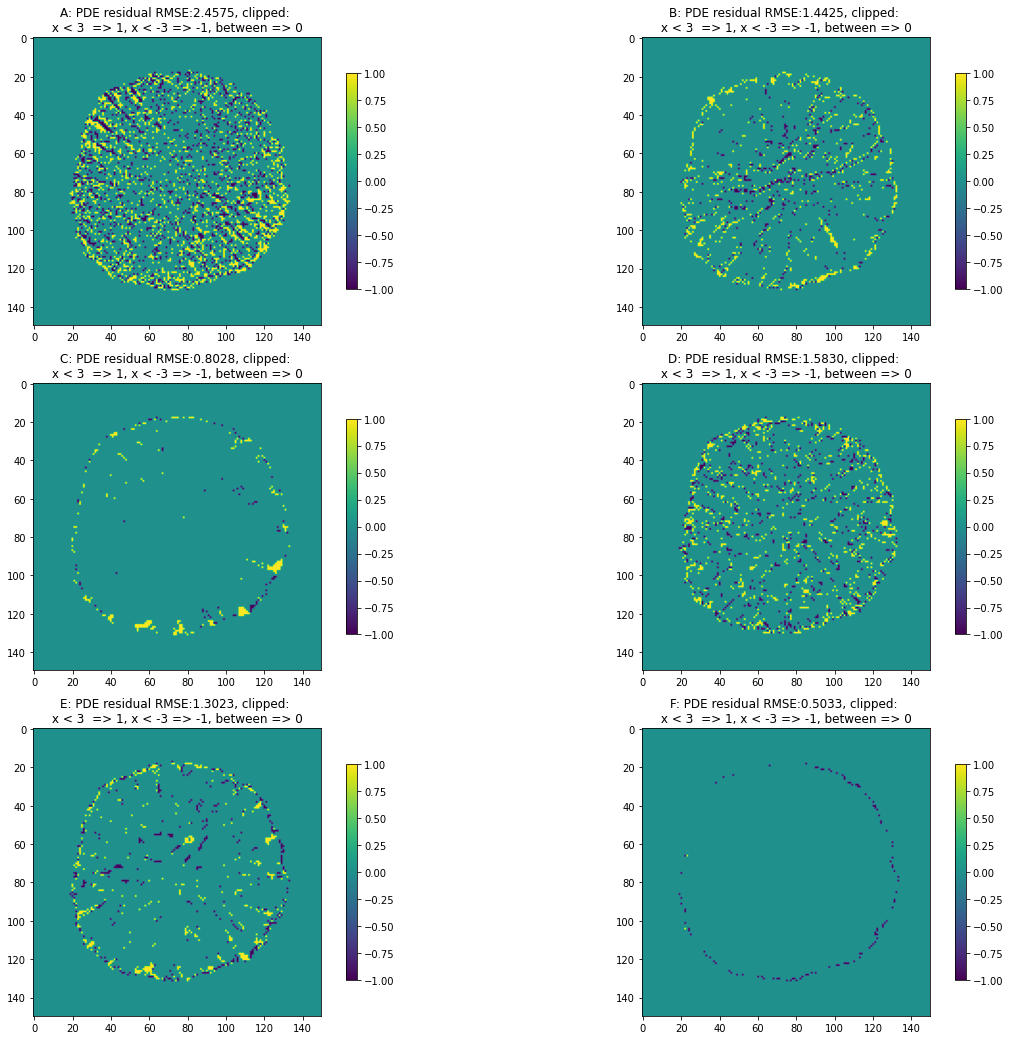

In [52]:
_ = plt.figure(figsize=(20,18))
max_L = 3
min_L = -3
for i, name in enumerate(node_names):
    plt.subplot(3, 2, i+1)
    d = test_pdes[i,:, :].copy()
    d[mask[:,:,t_star[T_test_index]] == 0] = 0
    rmse = np.sqrt(np.mean(d**2))
    plt.title(f"{name}: PDE residual RMSE:{rmse:.4f}, clipped: \n x < {max_L}  => 1, x < {min_L} => -1, between => 0 ")    
    d[(d >= min_L) & (d <= max_L)] = 0
    d[d > max_L] = 1
    d[d < min_L] = -1
    #d[d > 0] = 0
    plt.imshow(d)
    plt.colorbar(shrink=.75)

plt.show()